# Turing's model of morphogenesis and spectral methods
## The Gray-Scott model
Author: Michelle Contreras Cossio

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

 1. Implement the Gray-Scott equations in Python, using the spectral method and the method of lines. I've included the outline of my solution below, but feel free to structure your code differently. Use periodic boundary conditions here, because the Fourier transform requires them.
- Note that there are several possible ways to solve this problem: (1) exclusively in real-space (it's good practice not to use this approach here, since we already did it above for the Allen-Cahn model), (2) primarily in real-space, but switching to the Fourier domain and back within every call to the diffusion term, or (3) primarily working in the Fourier domain but switching back-and-forth to real space every time within the reaction term. If you opt for the last option, remember to convert your final solution back to real space.
- You will likely find the functions `np.fft.fft2()` and `np.fft.ifft2()` very useful here

In [5]:
from scipy.integrate import solve_ivp

class GrayScott:
    """
    Simulate the two-dimensional Gray-Scott model

    Parameters
        nx (int): number of grid points in the x direction
        ny (int): number of grid points in the y direction
        Lx (float): length of the domain in the x direction
        Ly (float): length of the domain in the y direction
        du (float): diffusion coefficient for u
        dv (float): diffusion coefficient for v
        kappa (float): degradation rate of v
        b (float): growth rate of u

    """

    def __init__(self, nx, ny, du=0.1, dv=0.05, b=0.0545, kappa=0.1165, Lx=1.0, Ly=1.0):
        self.nx, self.ny = nx, ny
        self.dx = Lx / nx
        self.dy = Ly / ny
        self.du, self.dv = du, dv
        self.kappa = kappa
        self.b = b
        
        ## We need to define a mesh for the frequency domain
        kx = (2 * np.pi / Lx) * np.hstack([np.arange(nx / 2 + 1), np.arange(1 - nx / 2, 0)]) / nx
        ky = (2 * np.pi / Ly) * np.hstack([np.arange(ny / 2 + 1), np.arange(1 - ny / 2, 0)]) / ny
        self.kx, self.ky = kx, ky
        kxx, kyy = np.meshgrid(kx, ky)

        ksq = kxx**2 + kyy**2
        self.ksq = ksq

        
    def _reaction(self, y):
        """
        Compute the reaction term in real space

        Args:
            y (np.ndarray): array of shape (2 * nx * ny, ) containing the two fields
                u and v, stacked together
        """
        # obtaining u and v 
        u = y[:self.ny * self.nx]
        v = y[-self.ny * self.nx:]

        # calculating reaction terms 
        u_react = -u * (v**2) + self.b * (1 - u)
        v_react = u * (v**2) - self.kappa * v
        react = np.hstack([u_react, v_react])
        return react 



    def _laplace(self, y):
        """
        Calculate the Laplacian in Fourier space
        """
        y = np.reshape(y, (self.nx, self.ny))
        y_fft = np.fft.fft2(y)

        # laplacian 
        L = np.fft.ifft2(-self.ksq * y_fft)

        return np.real(L).flatten()



    def _diffusion(self, y):
        """
        Calculate the diffusion term in Fourier space

        Args:
            y (np.ndarray): array of shape (2 * nx * ny, ) containing the two fields
                u and v, stacked together
        """
        # obtaining u and v 
        u = y[:self.ny * self.nx]
        v =  y[-self.ny * self.nx:]

        # calculating laplacians 
        L_u = self._laplace(u)
        L_v = self._laplace(v)

        u_dfsn = self.du * L_u
        v_dfsn = self.dv * L_v

        dfsn = np.hstack([u_dfsn, v_dfsn])
        return dfsn



    def rhs(self, t, y):
        """
        For technical reasons, this function needs to take a one-dimensional vector, 
        and so we have to reshape the vector back into the mesh
        """
        rhs_f = self._reaction(y) + self._diffusion(y)
        return rhs_f


    def solve(self, y0, t_min, t_max, nt, **kwargs):
        """
        Solve the heat equation using the solve_ivp solver

        Args:
            y0 (np.ndarray): initial condition
            t_min (float): minimum time
            t_max (float): maximum time
            nt (int): number of time steps
            **kwargs: keyword arguments to pass to solve_ivp

        """
        u0, v0 = y0
        t = np.linspace(t_min, t_max, nt)
        y0 = np.hstack([u0.flatten(), v0.flatten()])
        out = solve_ivp(self.rhs, (t_min, t_max), y0, t_eval=t, **kwargs)
        sol = out.y.T
        
        u = sol[:, :self.nx * self.ny]
        v = sol[:, self.nx * self.ny:]
        u = np.reshape(u, (nt, self.ny, self.nx))
        v = np.reshape(v, (nt, self.ny, self.nx))
        return t, np.stack([u, v], axis=-1)


Testing the code

Imaginary residual is: 0.0


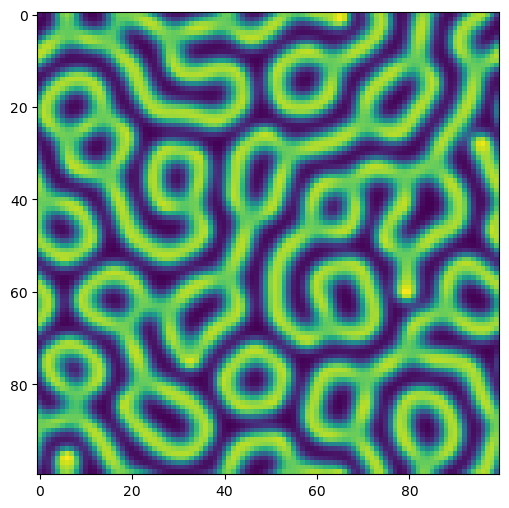

In [6]:
# Import William's solution
#from solutions.grayscott import GrayScott

## Create initial conditions
np.random.seed(0)
u_ic = 0.5 +  1.5 * np.random.random((100, 100))
v_ic = 1 - np.copy(u_ic)

## Run simulation
model = GrayScott(*u_ic.shape)
tpts, sol = model.solve([u_ic, v_ic], 0, 5000, 500)

## Check that our spectral code is working: the imaginary residual should be small
print(f"Imaginary residual is: {np.mean(np.abs(np.imag(np.array(sol))))}")
sol = np.real(sol)

plt.figure(figsize=(6, 6))
plt.imshow(sol[-1, ..., 1])

In [8]:
## Create an interactive plot using ipywidgets

from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

def plotter(i):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(sol[i, ..., 1])
    plt.show()



interact(
    plotter, 
    i=widgets.IntSlider(0, 0, len(sol) - 1, 1, layout=Layout(width='500px'))
)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='500px'), max=499), Output()), _…

<function __main__.plotter(i)>

2. Try varying the parameters $D_u$, $D_v$ and $\beta$ in your equations. How do the solutions change? Do you have any intuition for why these changes might occur?
3. We mentioned that performing Fourier transforms at each timestep is more expensive per mesh point than computing the discrete Laplacian at each timestep. Can you give a more mathematical reason for this advantage, based on runtime scaling of Fourier transforms? How many fewer mesh points would we need to compensate?
4. Try playing around with the number of timepoints and the number of space points. When does the spectral method fail? How do these failures differ from the ones we saw with the real-space finite difference scheme we used for the Allen-Cahn equations?
5. Evolutionary biologists recently showed strong evidence that [the spacing of teeth-like denticles on sharks' skin](https://www.science.org/doi/10.1126/sciadv.aau5484?cookieSet=1) arises from a Turing mechanism. If we suppose that the denticles form via a Turing instability in Gray-Scott equations in early development, which parameter of the Gray-Scott equations would evolutionary forces most strongly act upon?
6. We assumed periodic boundary conditions, which makes this problem easier to implement. How do you expect our results would change, if we had Dirichlet boundary conditions?

sorry I had a lot of homework and midterms, I'll answer the questions after the due date :(. but the code is done :)